In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

# Voting classifiers
Voting classifiers trains a group of classifiers and takes a majority vote of all the classifiers predictions. The majority vote can be either a hard vote or a soft vote. A soft vote is the weighted average of the probablilites, while a hard vote is just a mode.

<AxesSubplot:>

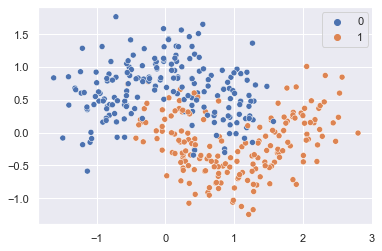

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

lr = LogisticRegression()
svc = SVC()
rf_clf = RandomForestClassifier(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf_clf), ('svc', svc)],
    voting='hard', # can be 'soft' if all the classifiers have 'predict_proba' method
    n_jobs=-1)


for clf in (lr, rf_clf, svc, voting_clf):
    clf.fit(X_train, y_train)
    print(clf.__class__.__name__, clf.score(X_test, y_test))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


## Bagging
Bagging is similar to a VotingClassifier, but instead of training different estimators on one training data set like a VotingClassifier, bagging uses one estimator (a DecisionTree) on different sub-samples of the training data set. If sub-sampling is done with replacement, then it is called bagging, whereas when sub-sampling is done without replacement it is called pasting. 

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [16]:
bag_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(min_samples_leaf=5), # hyperparameters can be set here
    n_estimators=500,
    max_samples=1.0,
    bootstrap=True, # if true, sample with replacement
    random_state=42, n_jobs=-1
)
bag_clf.fit(X_train, y_train).score(X_test, y_test)

0.896

<AxesSubplot:>

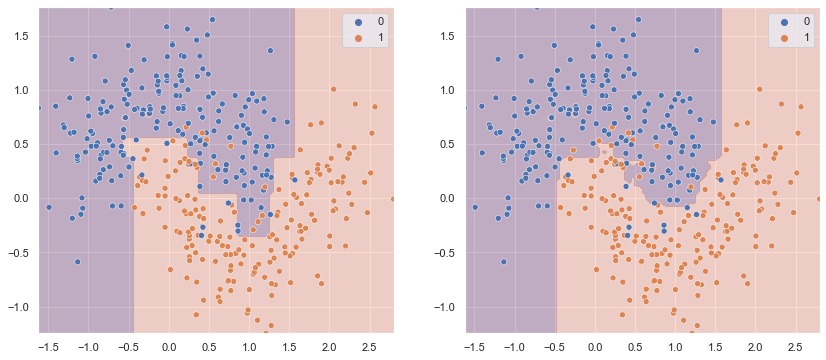

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
# left plot: decision tree
dt_clf = DecisionTreeClassifier(min_samples_leaf=5).fit(X_train, y_train)
x1 = np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 100)
x2 = np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 100)
xx, yy = np.meshgrid(x1, x2)
X_new = np.c_[xx.ravel(), yy.ravel()]
z = dt_clf.predict(X_new).reshape(xx.shape)
ax[0].contourf(xx, yy, z, levels=1, alpha=0.3)
sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train, ax=ax[0])

# right plot: bagging clf
z1 = bag_clf.predict(X_new).reshape(xx.shape)
ax[1].contourf(xx, yy, z1, levels=1, alpha=0.3)
sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train, ax=ax[1])

## Random Forests
Bagging provides a degree of randomness by sub-sampling the training dataset. Bagging also provides a way to sub-sample the features, by way of 'max_features' and 'bootstrap_features' hyperparameters. RandomForests do this automatically. 
- sampling both training instances and features is called random pathces,
- sampling only features, and keeping all the instances is called random subspaces.

BaggingClassifier can be provided with any 'base_estimator', whereas decision tree classifier is the default for RandomForestClassifer. Apart from that, RadnomForestClassifier has all the hyperparameters of a BaggingClassifier.

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(
    n_estimators=500,
    random_state=42, n_jobs=-1,
    min_samples_leaf=5
)
rf_clf.fit(X_train, y_train).score(X_test, y_test)

0.912

In [20]:
0.912 / 0.896

1.0178571428571428

**Notice** that random forest gives ~1.7% improvement over Bagging, just by uncorrelating the grown trees by way of random sampling of the features

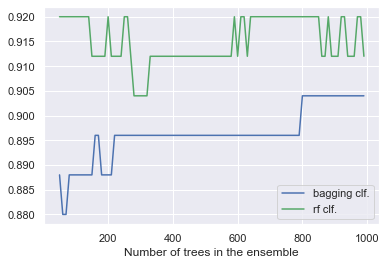

In [22]:
# random forest vs. bagging
bag_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(min_samples_leaf=5),
    max_samples=1.0,
    bootstrap=True,
    random_state=42, n_jobs=-1
)
rf_clf = RandomForestClassifier(
    random_state=42, n_jobs=-1,
    min_samples_leaf=5
)
bag_scores, rf_scores = [], []
n_estimators = range(50, 1000, 10)
for i in n_estimators:
    bag_clf.set_params(n_estimators=i)
    rf_clf.set_params(n_estimators=i)
    
    bag_clf.fit(X_train, y_train)
    rf_clf.fit(X_train, y_train)
    
    bag_scores.append(bag_clf.score(X_test, y_test))
    rf_scores.append(rf_clf.score(X_test, y_test))

plt.plot(n_estimators, bag_scores, 'b-', label='bagging clf.')
plt.plot(n_estimators, rf_scores, 'g-', label='rf clf.')
plt.xlabel('Number of trees in the ensemble')
plt.ylabel('accuracy score')
plt.legend();

In [23]:
np.mean(rf_scores) / np.mean(bag_scores)

1.0211406558301237

On an average, random forest provides ~2.1% improvement over bagging.

## Featrue improtance
Decision trees, bagging & random forests provide feature importance based on how much the tree nodes that use a feature reduce node impurtiy on average.

(-0.5, 27.5, 27.5, -0.5)

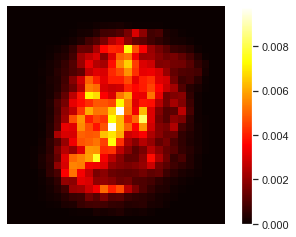

In [27]:
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
import matplotlib as mpl 

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(mnist.data, mnist.target)
print(accuracy_score(mnist.target, rf_clf.predict(mnist.data)))
plt.imshow(rf_clf.feature_importances_.reshape(28, 28), 
           cmap=mpl.cm.hot, interpolation='nearest')
plt.colorbar()
plt.axis('off')

## AdaBoost

In [30]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=500,
    algorithm='SAMME.R', learning_rate=0.5)
ada_clf.fit(X_train, y_train).score(X_test, y_test)

0.88

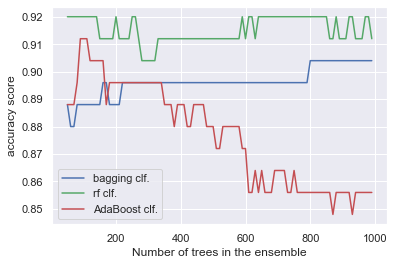

In [32]:
# adaboost vs. bagging vs. random forest
ada_scores = []
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    algorithm='SAMME.R', learning_rate=0.5)
n_estimators = range(50, 1000, 10)
for i in n_estimators:
    ada_clf.set_params(n_estimators=i)
    ada_clf.fit(X_train, y_train)
    ada_scores.append(ada_clf.score(X_test, y_test))

plt.plot(n_estimators, bag_scores, 'b-', label='bagging clf.')
plt.plot(n_estimators, rf_scores, 'g-', label='rf clf.')
plt.plot(n_estimators, ada_scores, 'r-', label='AdaBoost clf.')
plt.xlabel('Number of trees in the ensemble')
plt.ylabel('accuracy score')
plt.legend();

## GradientBoosting
Like AdaBoost, GradientBoosting sequentially adds estimators to the ensemble. Each successive estimator improves on the previous one by training on the residuals of the previous estimators predictions.

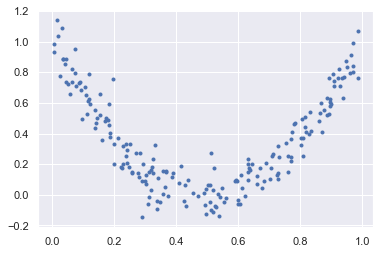

In [51]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10
y = y.reshape(-1)
plt.plot(X.flatten(), y, 'b.')

In [53]:
from sklearn.tree import DecisionTreeRegressor
reg1 = DecisionTreeRegressor(max_depth=2).fit(X, y)
y_pred = reg1.predict(X)

y2 = y - y_pred
reg2 = DecisionTreeRegressor(max_depth=2).fit(X, y2)
y2_pred = reg2.predict(X)

y3 = y2 - y2_pred
reg3 = DecisionTreeRegressor(max_depth=2).fit(X, y3)
y3_pred = reg3.predict(X)

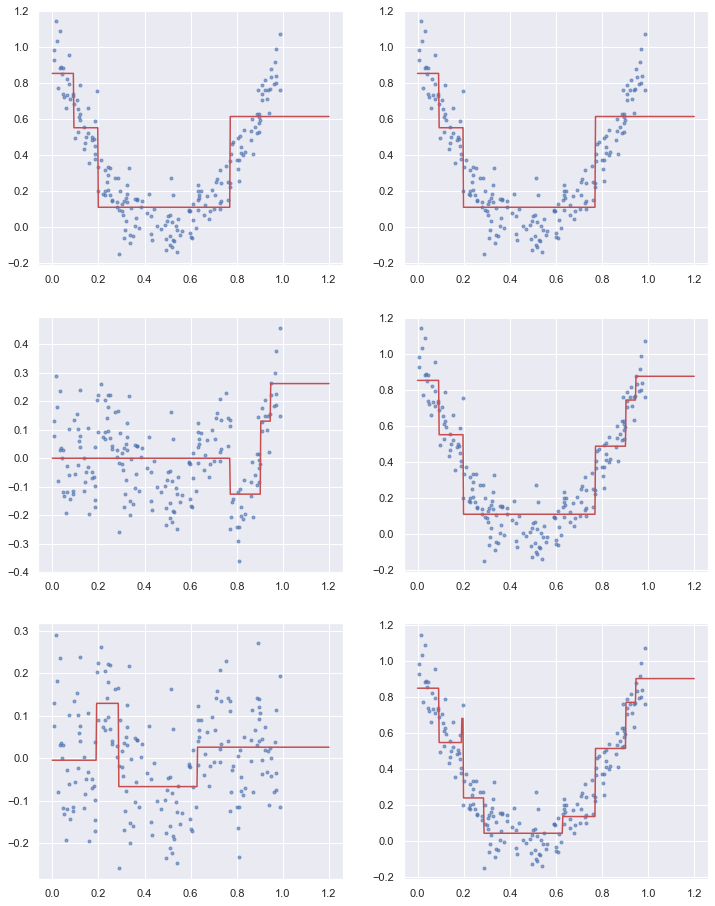

In [57]:
X_new = np.linspace(0, 1.2, 500).reshape(-1, 1)
f, ax = plt.subplots(3, 2, figsize=(12, 16))
ax = ax.ravel()

ax[0].plot(X.ravel(), y, 'b.', alpha=0.6)
y_new = reg1.predict(X_new)
ax[0].plot(X_new, y_new, 'r-')
ax[1].plot(X.ravel(), y, 'b.', alpha=0.6)
ax[1].plot(X_new, y_new, 'r-')

ax[2].plot(X.ravel(), y2, 'b.', alpha=0.6)
y2_new = reg2.predict(X_new)
ax[2].plot(X_new, y2_new, 'r-')
ax[3].plot(X.ravel(), y, 'b.', alpha=0.6)
ax[3].plot(X_new, y_new + y2_new, 'r-')

ax[4].plot(X.ravel(), y3, 'b.', alpha=0.6)
y3_new = reg3.predict(X_new)
ax[4].plot(X_new, y3_new, 'r-')
ax[5].plot(X.ravel(), y, 'b.', alpha=0.6)
ax[5].plot(X_new, y_new + y2_new + y3_new, 'r-')

The same can be achieved through sklearn's GradientBoostingRegressor, as shown below

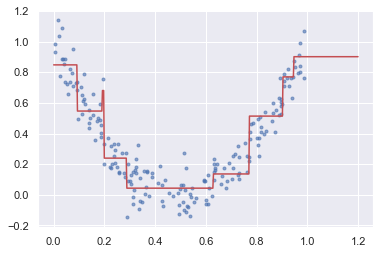

In [58]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(n_estimators=3, max_depth=2, learning_rate=1.0)
gbrt.fit(X, y)
plt.plot(X, y, 'b.', alpha=0.6)
plt.plot(X_new, gbrt.predict(X_new), 'r-')

## How to find the optimal number of trees in GradientBoost ensemble?
### 1: Train a large number of trees and pick the best one
Below, train 120 trees and then pick the best number of trees using 'staged_predict' method.

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)
gbrt = GradientBoostingRegressor(n_estimators=120, max_depth=2).fit(xtrain, ytrain)
mse = [mean_squared_error(ytest, ypred) for ypred in gbrt.staged_predict(xtest)]
best_n_trees = np.argmin(mse) + 1
best_n_trees

46

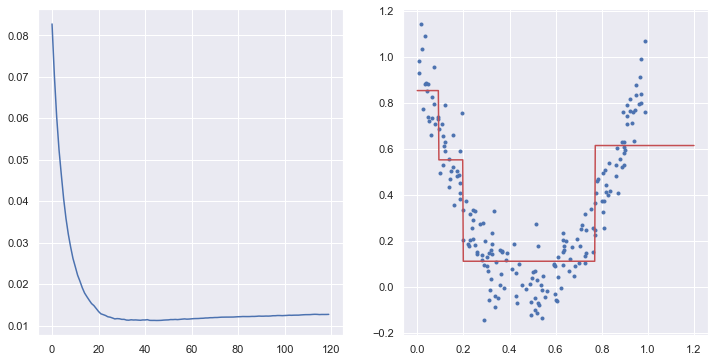

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(mse)
ax[1].plot(X.ravel(), y, 'b.')
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_trees)
y_new_pred = gbrt.fit(X, y).predict(X)
ax[1].plot(X_new, y_new, 'r-')

### 2. The other approach is to use early stopping

# Exercises

## 8: MNIST data set

In [68]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

TypeError: unhashable type: 'slice'

In [72]:
# mnist data set is already shuffed
xtrain, xvalid, xtest = mnist.data[:50000], mnist.data[50000:60000], mnist.data[60000:]
ytrain, yvalid, ytest = mnist.target[:50000], mnist.target[50000:60000], mnist.target[60000:]
xtrain.shape, xvalid.shape, xtest.shape

((50000, 784), (10000, 784), (10000, 784))

In [73]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC

In [74]:
rf_clf = RandomForestClassifier()
et_clf = ExtraTreesClassifier()

rf_clf.fit(xtrain, ytrain)
et_clf.fit(xtrain, ytrain)

rf_clf.score(xvalid, yvalid), et_clf.score(xvalid, yvalid)

(0.9723, 0.9762)

In [76]:
voting_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('et', et_clf)],
    voting='hard')
voting_clf.fit(xtrain, ytrain)
voting_clf.score(xvalid, yvalid)

0.9725

In [77]:
voting_clf.estimators

[('rf', RandomForestClassifier()), ('et', ExtraTreesClassifier())]

In [78]:
voting_clf.estimators_

[RandomForestClassifier(), ExtraTreesClassifier()]

In [79]:
# let's look if soft voting improves score
voting_clf.voting = 'soft'
voting_clf.score(xvalid, yvalid)

0.9744

In [80]:
# test set scores
print(voting_clf.score(xtest, ytest))
print([clf.score(xtest, ytest) for clf in voting_clf.estimators_])

0.9719
[0.9687, 0.9709]
